In [30]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if '_original_image.png' in f]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        mask_name = os.path.join(self.root_dir, self.image_files[idx].replace('_original_image.png', '_original_image_0_segmentation.png'))
        
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('RGB')
        mask = self.convert_mask(mask)
            
        if self.transform:
            image = self.transform(image)
            if not isinstance(mask, torch.Tensor):
                mask = self.transform(mask)

        return image, mask
    
    def convert_mask(self, mask_image):
        arr = np.array(mask_image)
        labels = np.zeros(arr.shape[:2], dtype=np.uint8)  # Фон по умолчанию
        red_condition = (arr[:,:,0] > arr[:,:,1]) & (arr[:,:,0] > arr[:,:,2])
        blue_condition = (arr[:,:,2] > arr[:,:,0]) & (arr[:,:,2] > arr[:,:,1])
        labels[red_condition] = 1
        labels[blue_condition] = 2
        return torch.from_numpy(labels)

transform = transforms.Compose([
    transforms.ToTensor()
])

# Создаем экземпляр датасета
dataset = PlantDataset(root_dir="/kaggle/input/weeder-dandelions-vs-radishes/dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


## Разделение датасета


In [31]:
from torch.utils.data.dataset import random_split

# Сначала разделим датасет на train и val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


## Определение модели U-Net

In [23]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

model = UNet(in_channels=3, out_channels=3)  # 3 output channels: dandelion, radish, background


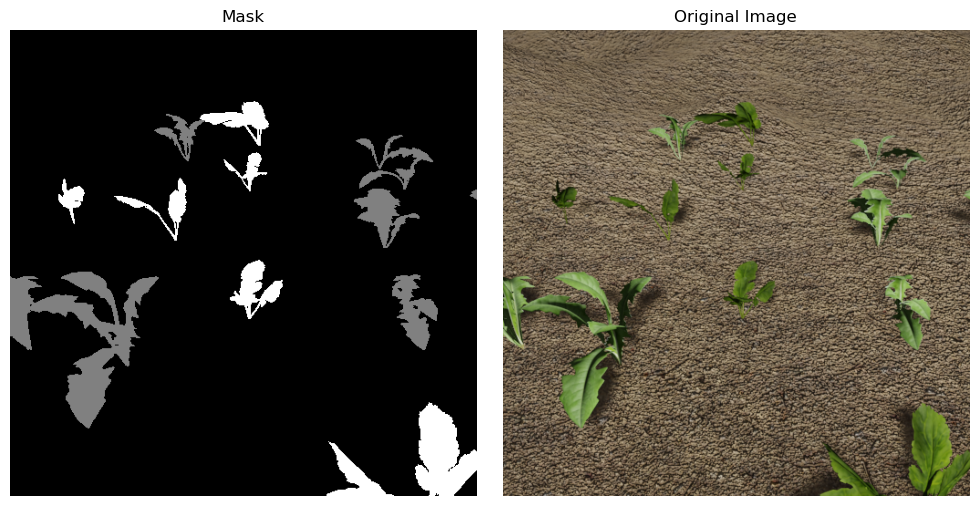

In [24]:
import matplotlib.pyplot as plt

# Получаем первую пару изображение-маска из датасета
image, mask = next(iter(dataloader))

# Выводим изображение маски
plt.figure(figsize=(10, 5))

# Визуализация маски
plt.subplot(1, 2, 1)
plt.title("Mask")
plt.imshow(mask[0][0], cmap='gray')
plt.axis('off')

# Визуализация оригинального изображения
plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.imshow(image[0].permute(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()


## Обучение модели

Epoch 1/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s]


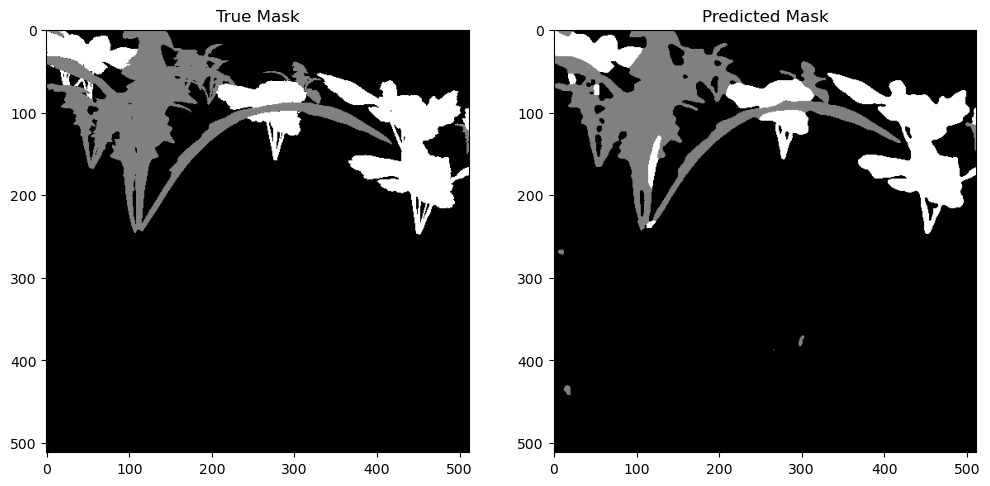

Epoch 1/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.12it/s]


Epoch 1/10, Train Loss: 0.0498, Val Loss: 0.0379


Epoch 2/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s]


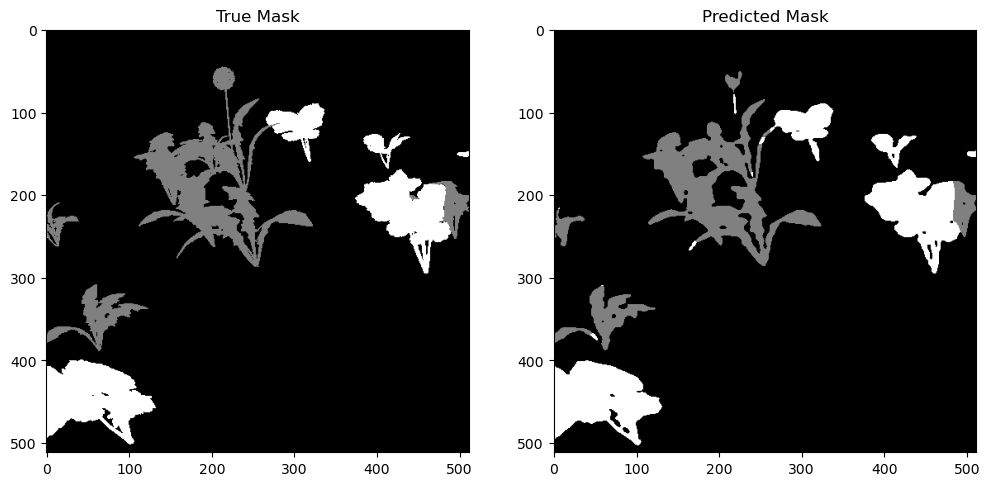

Epoch 2/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.25it/s]


Epoch 2/10, Train Loss: 0.0470, Val Loss: 0.0380


Epoch 3/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s]


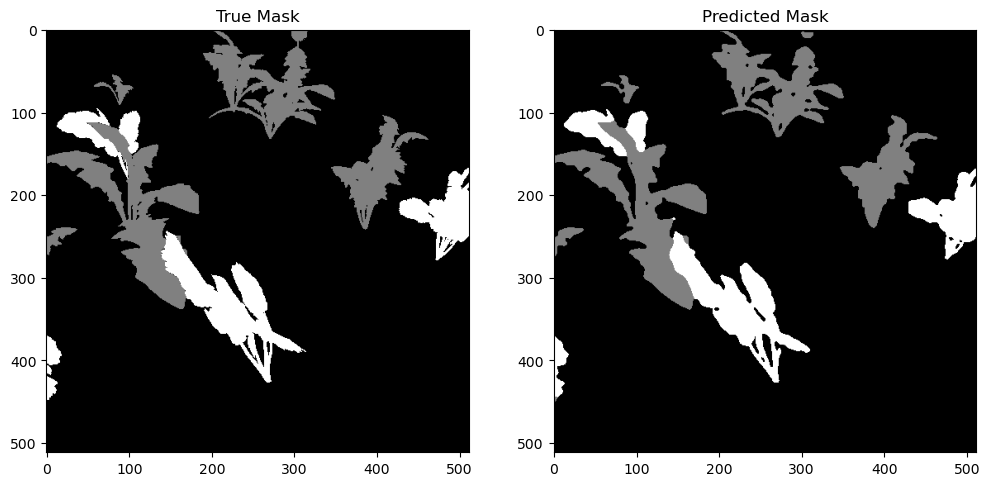

Epoch 3/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.23it/s]


Epoch 3/10, Train Loss: 0.0452, Val Loss: 0.0347


Epoch 4/10 - Training: 100%|██████████| 375/375 [01:26<00:00,  4.34it/s]


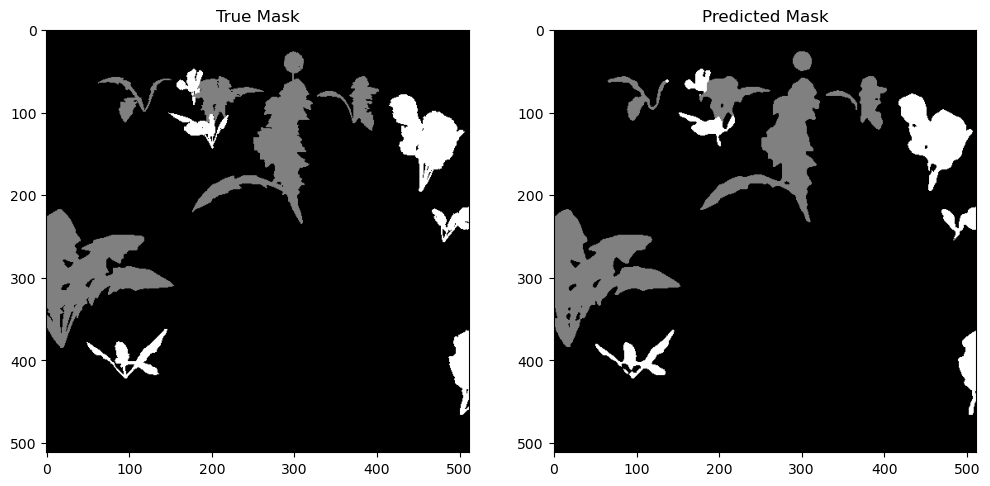

Epoch 4/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.04it/s]


Epoch 4/10, Train Loss: 0.0434, Val Loss: 0.0356


Epoch 5/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.43it/s]


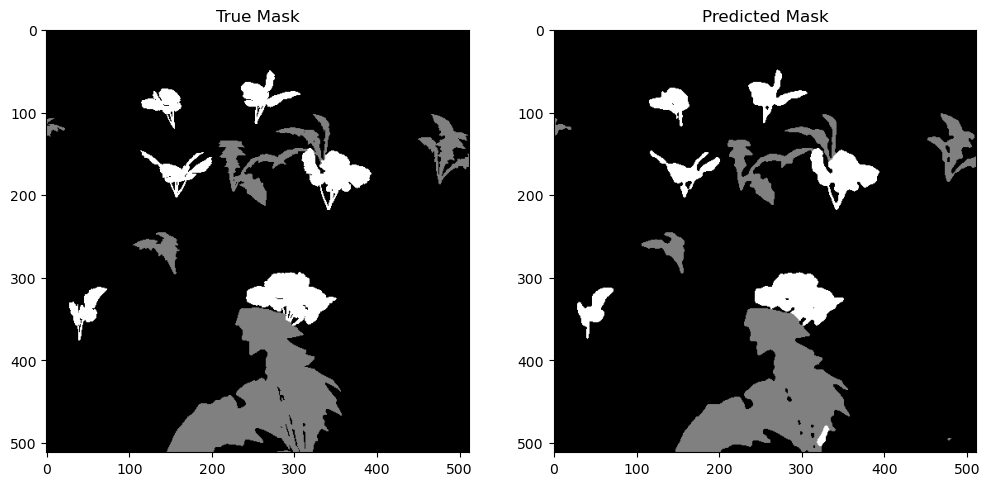

Epoch 5/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.25it/s]


Epoch 5/10, Train Loss: 0.0413, Val Loss: 0.0330


Epoch 6/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.44it/s]


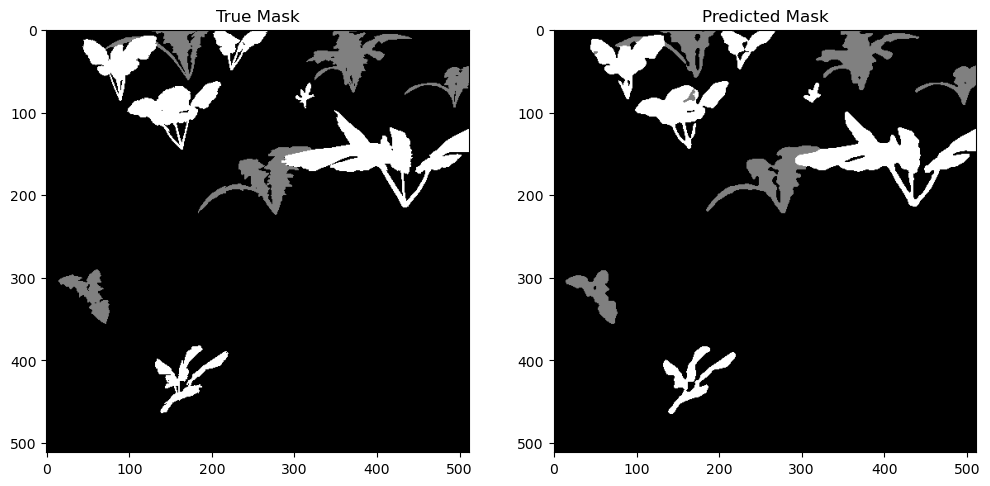

Epoch 6/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.04it/s]


Epoch 6/10, Train Loss: 0.0450, Val Loss: 0.0367


Epoch 7/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.43it/s]


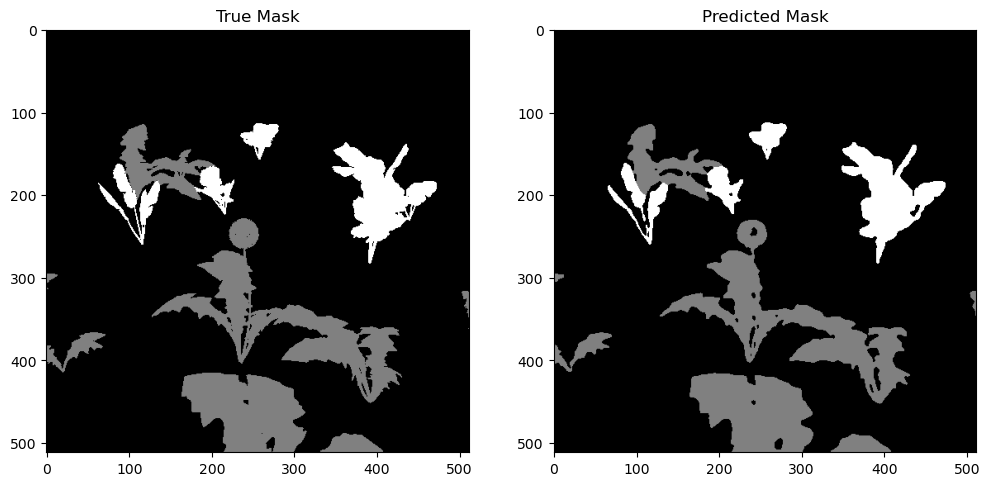

Epoch 7/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.16it/s]


Epoch 7/10, Train Loss: 0.0424, Val Loss: 0.0323


Epoch 8/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s]


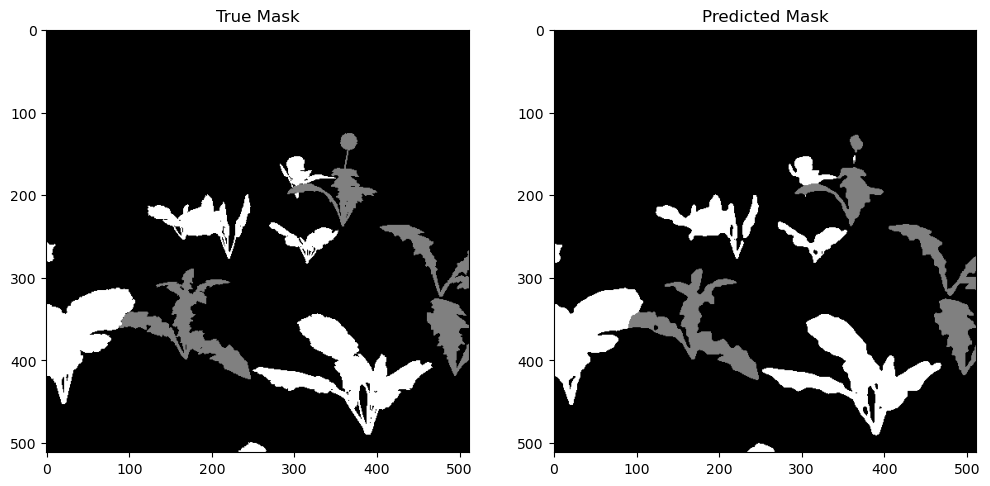

Epoch 8/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.00it/s]


Epoch 8/10, Train Loss: 0.0413, Val Loss: 0.0351


Epoch 9/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s]


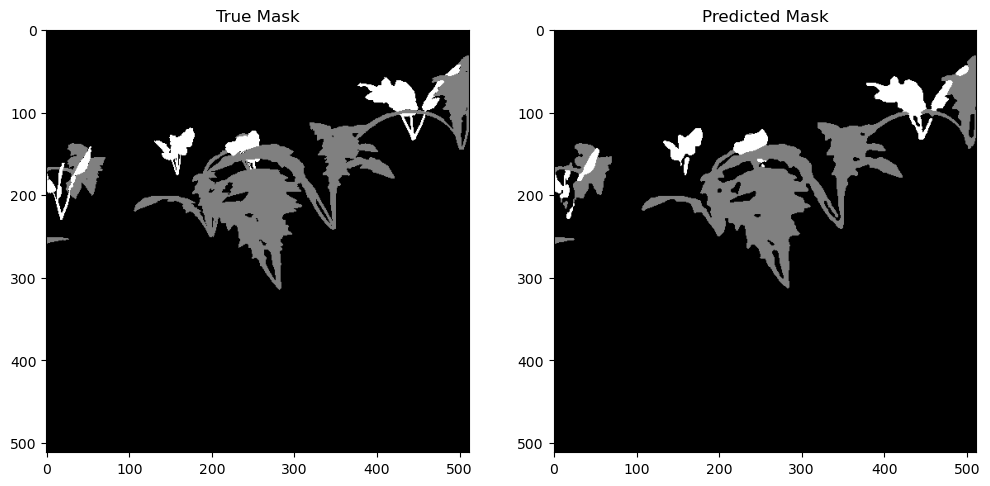

Epoch 9/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.10it/s]


Epoch 9/10, Train Loss: 0.0392, Val Loss: 0.0309


Epoch 10/10 - Training: 100%|██████████| 375/375 [01:24<00:00,  4.41it/s]


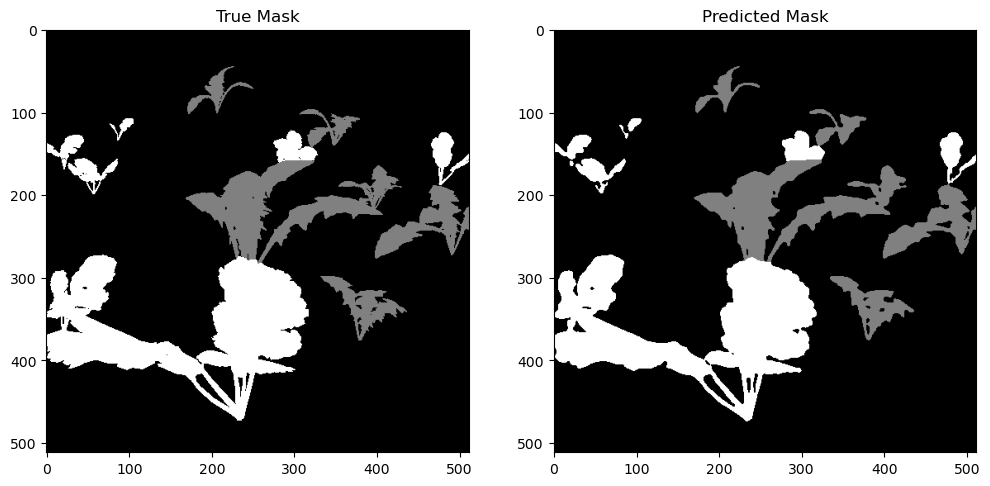

Epoch 10/10 - Validation: 100%|██████████| 75/75 [00:10<00:00,  7.05it/s]

Epoch 10/10, Train Loss: 0.0374, Val Loss: 0.0298


In [33]:
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагается, что у вас уже есть определение UNet
# model = UNet(in_channels=3, out_channels=3).to(device)


optimizer = optim.Adam(model.parameters(), lr=0.0003)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
#     for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device).squeeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
#         masks = torch.argmax(masks, dim=1)

        loss = F.cross_entropy(outputs, masks.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
     # Выводим изображения
    mask_output = torch.argmax(outputs[0], dim=0).cpu().numpy()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(masks[0].cpu().numpy(), cmap='gray')
    plt.title('True Mask')
    plt.subplot(1, 2, 2)
    plt.imshow(mask_output, cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

    train_loss = train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device).squeeze(1)
            outputs = model(images)
#             masks = torch.argmax(masks, dim=1)  
            loss = F.cross_entropy(outputs, masks.long())
            val_loss += loss.item()
            
    val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [35]:
# Сохранение
torch.save(model, 'segmentation.pt')
# Сохранение
torch.save(model.state_dict(), 'segmentation_weights.pt')


# # Загрузка
# model = torch.load('path_to_file.pt')
# # Загрузка (предполагая, что вы уже определили структуру модели в переменной `model`)
# model.load_state_dict(torch.load('path_to_weights.pt'))
# model.eval()  # Не забудьте вызвать этот метод, если модель будет использоваться для инференции


# Boundary box

In [2]:
import cv2
import numpy as np

def get_bounding_boxes(image_path, threshold=150, min_size=3):
    # Загружаем изображение
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Бинаризуем изображение
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Находим контуры
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for contour in contours:
        # Получаем координаты Bounding Box
        x, y, w, h = cv2.boundingRect(contour)
        
        # Проверяем размер
        if w > min_size and h > min_size:
            # Если размер больше заданного порога, добавляем box в список
            boxes.append((x, y, x+w, y+h))

    return boxes, image


import matplotlib.pyplot as plt

def visualize_boxes(image, boxes):
    # Создаем копию изображения, чтобы не модифицировать оригинал
    img_copy = image.copy()

    for (x1, y1, x2, y2) in boxes:
        cv2.circle(img_copy, (x1, y1), 3, (0, 0, 255), -1)
        cv2.circle(img_copy, (x2, y1), 3, (0, 0, 255), -1)
        cv2.circle(img_copy, (x1, y2), 3, (0, 0, 255), -1)
        cv2.circle(img_copy, (x2, y2), 3, (0, 0, 255), -1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


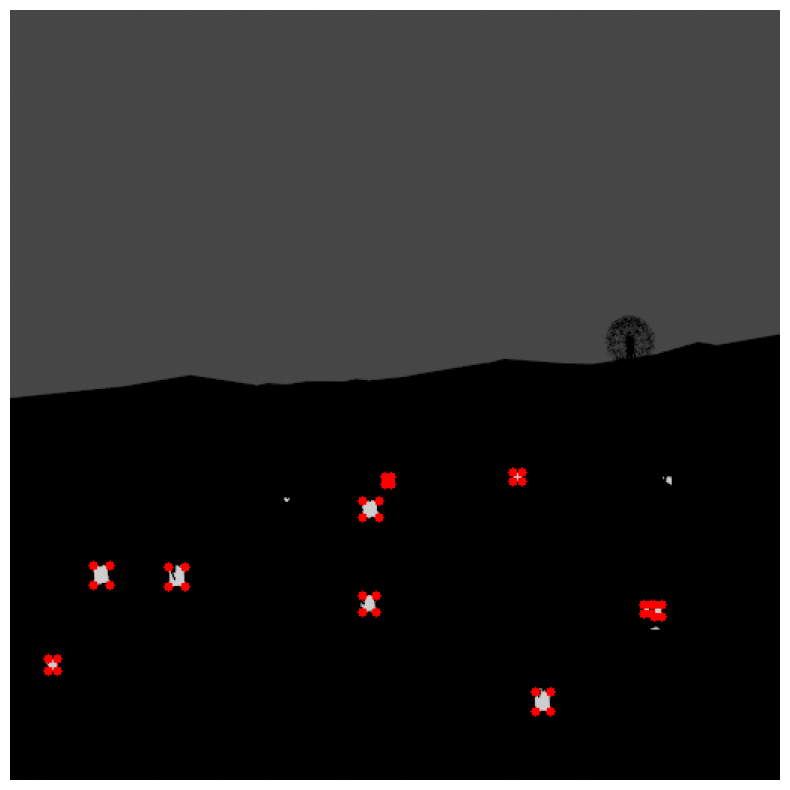

In [3]:
image_path = '/kaggle/input/weeder-dandelions-vs-radishes/dataset/0001_original_image_boundary.png'
boxes, image = get_bounding_boxes(image_path)
visualize_boxes(image, boxes)

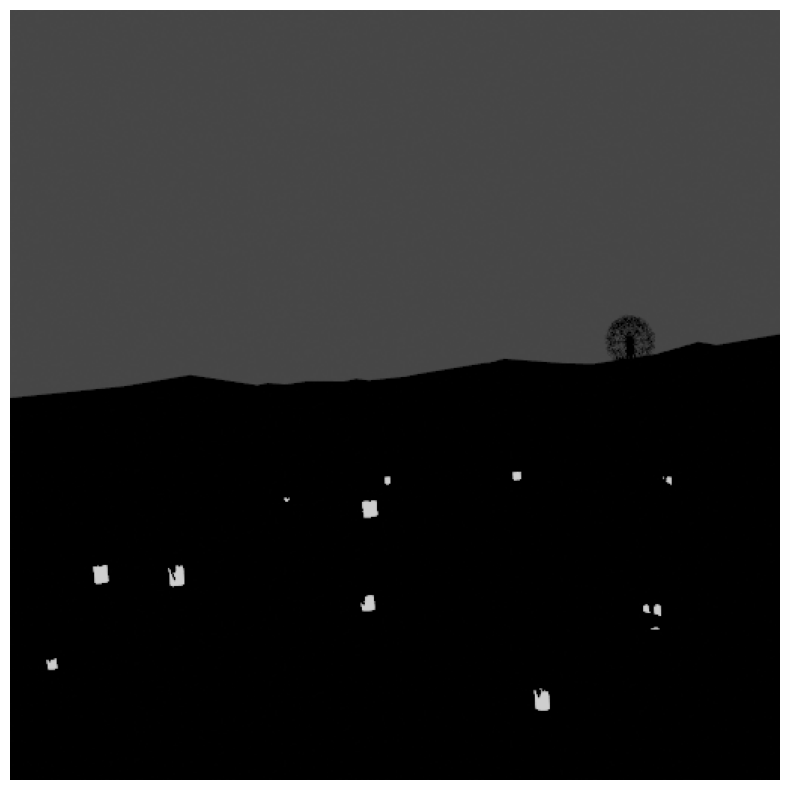

In [4]:
image = cv2.imread('/kaggle/input/weeder-dandelions-vs-radishes/dataset/0001_original_image_boundary.png', cv2.IMREAD_COLOR)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


[(421, 395, 433, 403), (249, 310, 253, 315), (349, 453, 359, 466), (105, 370, 116, 383), (234, 389, 243, 400), (25, 431, 31, 439), (55, 369, 66, 382), (234, 326, 245, 337), (334, 307, 340, 313)]


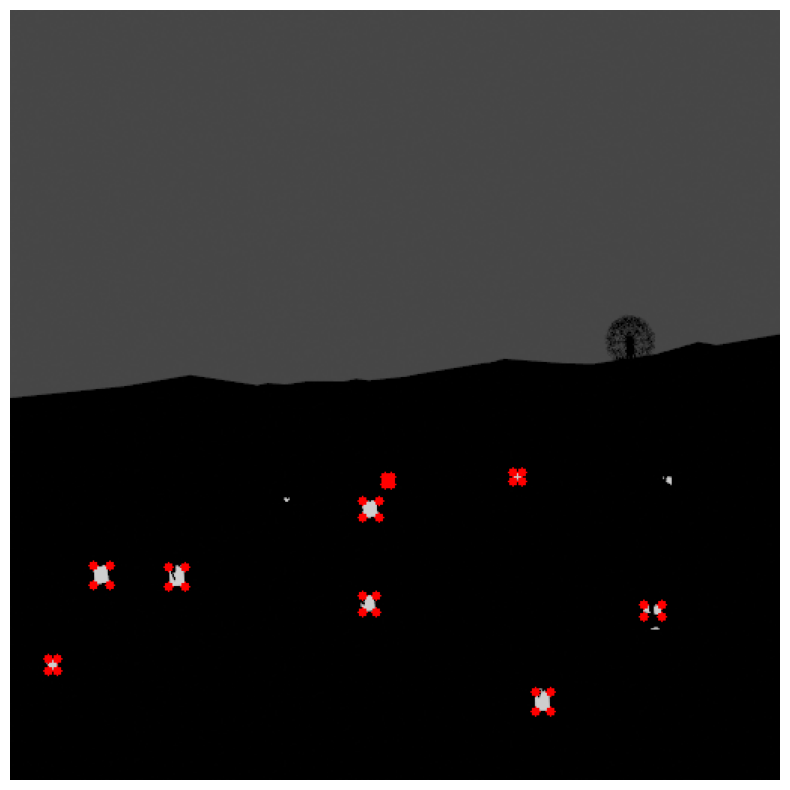

In [5]:
import csv
from collections import defaultdict


def coverage(box1, box2):
    """ 
    Вычисляем отношение площади пересечения двух блоков к площади box1.
    """
    x1, y1, x2, y2 = box1
    x1_b, y1_b, x2_b, y2_b = box2

    inter_x1 = max(x1, x1_b)
    inter_y1 = max(y1, y1_b)
    inter_x2 = min(x2, x2_b)
    inter_y2 = min(y2, y2_b)

    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)

    return inter_area / float(box1_area)


def merge_overlapping_boxes(predicted_boxes, true_boxes, coverage_threshold=0.95):
    corrected_boxes = []
    merged = set()

    for true_box in true_boxes:
        overlapping_boxes = []
        for i, pred_box in enumerate(predicted_boxes):
            # Используем coverage вместо IoU
            if coverage(pred_box, true_box) > coverage_threshold and i not in merged:
                overlapping_boxes.append(pred_box)
                merged.add(i)

        if overlapping_boxes:
            x_min = min(box[0] for box in overlapping_boxes)
            y_min = min(box[1] for box in overlapping_boxes)
            x_max = max(box[2] for box in overlapping_boxes)
            y_max = max(box[3] for box in overlapping_boxes)
            corrected_boxes.append((x_min, y_min, x_max, y_max))
    
    for i, pred_box in enumerate(predicted_boxes):
        if i not in merged:
            corrected_boxes.append(pred_box)
    
    return corrected_boxes


def load_true_boxes_from_csv(csv_file):
    true_boxes = defaultdict(list)
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Пропустим заголовок
        for row in reader:
            image_number = row[0]
            box = tuple(map(int, row[1:]))  # Преобразуем строковые значения в целые числа
            true_boxes[image_number].append(box)
    return true_boxes

def process_image(image_path, true_boxes_dict):
    # Получаем bounding box'ы из изображения
    predicted_boxes, image = get_bounding_boxes(image_path)
    
    # Получаем номер изображения из имени файла
    image_number = image_path.split('/')[-1].split('_')[0]
    
    # Если у нас есть истинные bounding box'ы для данного изображения, объединяем предсказанные box'ы
    true_boxes = true_boxes_dict.get(image_number, [])
    
    corrected_boxes = merge_overlapping_boxes(predicted_boxes, true_boxes)
        
    return corrected_boxes, image


csv_file = "/kaggle/input/weeder-dandelions-vs-radishes/dataset/cylinder_bboxes.csv"
true_boxes_dict = load_true_boxes_from_csv(csv_file)

image_path = "/kaggle/input/weeder-dandelions-vs-radishes/dataset/0001_original_image_boundary.png"
corrected_boxes, image = process_image(image_path, true_boxes_dict)
print(corrected_boxes)

visualize_boxes(image, corrected_boxes)

In [6]:
import os

def process_bbox_images(directory_path, true_boxes_dict):
    # Получаем список всех файлов в директории
    all_files = os.listdir(directory_path)
    
    # Фильтруем список файлов, чтобы оставить только те, которые соответствуют нашему шаблону
    image_files = [f for f in all_files if f.endswith("_original_image_boundary.png")]
    
    
    # Словарь для хранения результатов
    results_dict = {}
    
    for n, image_file in enumerate(image_files):
        if (n+1) % 1000 == 0:
            print(n+1)
        image_path = os.path.join(directory_path, image_file)
        corrected_boxes, image = process_image(image_path, true_boxes_dict)
        image_number = image_file.split('_')[0]
        results_dict[image_number] = corrected_boxes
    
    return results_dict

# Вызовем функцию и обработаем все изображения в указанной директории
dataset_folder = '/kaggle/input/weeder-dandelions-vs-radishes/dataset/'
bboxes_dict = process_bbox_images(dataset_folder, true_boxes_dict)


1000


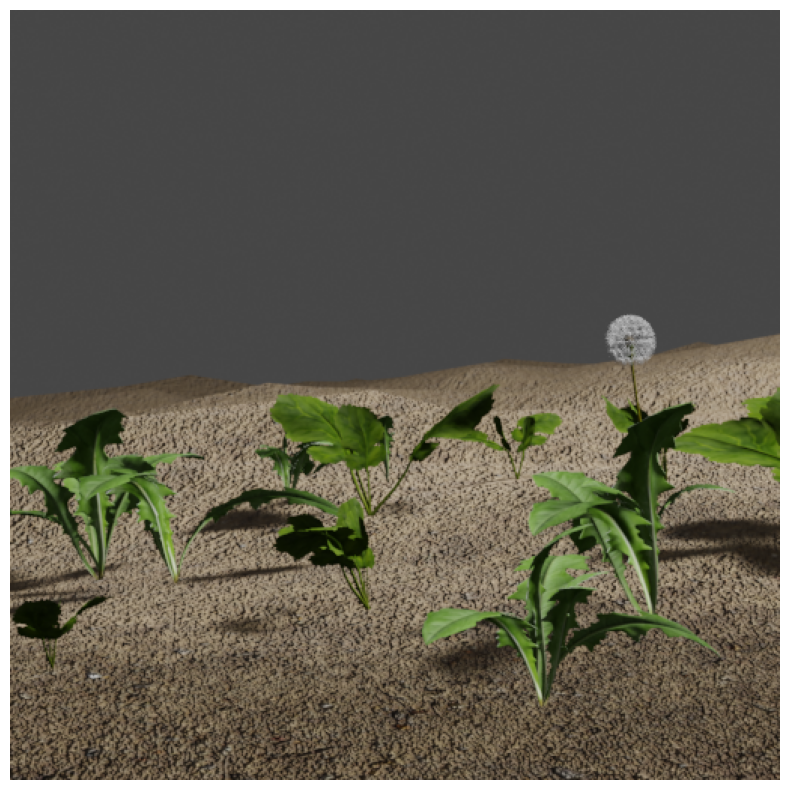

In [7]:
image = cv2.imread('/kaggle/input/weeder-dandelions-vs-radishes/dataset/0001_original_image.png', cv2.IMREAD_COLOR)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Подготовка датасета

In [8]:
def convert_to_center_format(box):
    """
    Преобразование координат bounding box в формат (x_center, y_center, width, height).
    """
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + (width / 2)
    y_center = y_min + (height / 2)
    return (x_center, y_center, width, height)


bboxes_n_dict = {}

for image_path, boxes in bboxes_dict.items():
    bboxes_n_dict[image_path] = [convert_to_center_format(box) for box in boxes]


In [9]:
bboxes_n_dict['0001']

[(427.0, 399.0, 12, 8),
 (251.0, 312.5, 4, 5),
 (354.0, 459.5, 10, 13),
 (110.5, 376.5, 11, 13),
 (238.5, 394.5, 9, 11),
 (28.0, 435.0, 6, 8),
 (60.5, 375.5, 11, 13),
 (239.5, 331.5, 11, 11),
 (337.0, 310.0, 6, 6)]

## Yolos модель

### coco аннотация

In [10]:
import os
import json

def convert_to_coco_format(data, image_folder):
    # Создаем основные структуры для COCO формата
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "object"}  # Мы предполагаем, что у вас только одна категория, называемая "object"
        ]
    }
    
    annotation_id = 0  # ID для аннотаций
    image_id = 0  # ID для изображений
    
    for image_name, bboxes in data.items():
        # Получаем полный путь к изображению
        image_path = os.path.join(image_folder, f"{image_name}_original_image.png")
        
        # Пропускаем, если такого изображения нет
        if not os.path.exists(image_path):
            continue

        # Добавляем информацию об изображении
        coco_format["images"].append({
            "file_name": f"{image_name}_original_image.png",
            "id": image_id,
            "height": 512,  # предположим, что у всех изображений одинаковый размер, замените на ваше значение
            "width": 512,  # замените на ваше значение, если это не так
        })
        
        # Добавляем аннотации
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min
            
            coco_format["annotations"].append({
                "image_id": image_id,
                "bbox": [x_min, y_min, width, height],
                "category_id": 1,
                "id": annotation_id,
                "area": width * height,
                "iscrowd": 0,  # предположим, что объекты не перекрываются
            })
            
            annotation_id += 1
        
        image_id += 1

    return coco_format

image_folder = "/kaggle/input/weeder-dandelions-vs-radishes/dataset"

coco_data = convert_to_coco_format(bboxes_dict, image_folder)

# Сохраняем данные в формате COCO в файл
with open("coco_annotations.json", "w") as f:
    json.dump(coco_data, f)


In [11]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 14.5 MB/s eta 0:00:00


In [12]:
import torchvision
import os
from transformers import AutoFeatureExtractor

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() 
        target = encoding["labels"][0]

        return pixel_values, target

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-tiny", size=512, max_size=864)

img_folder = '/kaggle/input/weeder-dandelions-vs-radishes/dataset'
ann_file = '/kaggle/working/coco_annotations.json'

train_dataset = CocoDetection(img_folder=img_folder, ann_file=ann_file, feature_extractor=feature_extractor)

from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [36]:
import pytorch_lightning as pl
from transformers import AutoModelForObjectDetection
import torch

class YOLOSTrainer(pl.LightningModule):
    def __init__(self, lr, weight_decay, num_labels):
        super(YOLOSTrainer, self).__init__()
        self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny", 
                                                             num_labels=num_labels,
                                                             ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        return self.model(pixel_values=pixel_values)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
        outputs = self.model(pixel_values=pixel_values, labels=labels)

        return outputs.loss, outputs.loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return train_dataloader

# Тренировка модели
model = YOLOSTrainer(lr=2.5e-5, weight_decay=1e-4, num_labels=2)
trainer = pl.Trainer(devices=1,max_steps=10000, gradient_clip_val=0.1, accumulate_grad_batches=4)
trainer.fit(model)


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([3, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training: 0it [00:00, ?it/s]

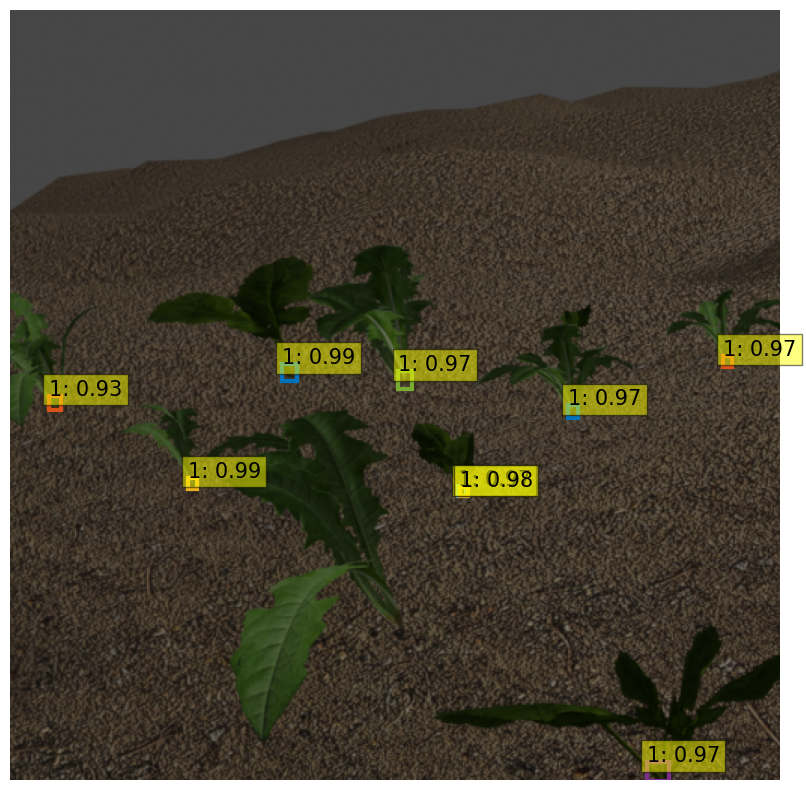

In [38]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

# цвета для визуализации
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# преобразование bounding box
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# масштабирование bounding box к размеру изображения
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# визуализация результатов
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{cl.item()}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(original_image, outputs, threshold=0.9):
    pil_img = original_image
    
    # Сохранение только прогнозов с уверенностью >= пороговому значению
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # Преобразование предсказанных bounding boxes к масштабам изображения
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), pil_img.size)

    # Визуализация результатов
    plot_results(pil_img, probas[keep], bboxes_scaled)

# Пример использования
pixel_values, _ = train_dataset[2]

# Получение оригинального изображения
original_image, _ = super(CocoDetection, train_dataset).__getitem__(2)

with torch.no_grad():
    outputs = model(pixel_values.unsqueeze(0).to(model.device))
    
visualize_predictions(original_image, outputs)



In [39]:
# Сохранение
torch.save(model, 'boundary_yolos_v2.pt')
# Сохранение
torch.save(model.state_dict(), 'boundary_yolos_v2_weights.pt')